<a href="https://colab.research.google.com/github/gowun/BladderCancer_AMC/blob/2-gowun/Notebooks/Classifier_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, roc_auc_score, average_precision_score
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

pd.set_option('display.max_colwidth', -1)

auth.authenticate_user()
drive.mount('/content/gdrive')
home_path = '/content/gdrive/My Drive/BladderCancer_AMC/'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AG4_Maok27Hwx5Vy7AITPomMnk7q9eYODFO9_wibni-7RruECTK38M
Mounted at /content/gdrive


In [2]:
!git clone -b 2-gowun https://github.com/gowun/BladderCancer_AMC.git

Cloning into 'BladderCancer_AMC'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 91 (delta 33), reused 54 (delta 17), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
from BladderCancer_AMC.ModelingTools import utils as ut

In [4]:
data_labels = ['MDA_MVAC', 'MDA_DDMVAC', 'Meta_Datasets', 'AMC']
classifiers = ut.load_data(home_path + 'intersect_classifiers.pkl', 'pickle')
datasets = ut.load_data(f'{home_path}scaled_datasets_3mths.pkl', 'pickle')

In [5]:
classifiers.keys()

dict_keys(['Metacore&GSEA target genes', 'GSEA_R enrichment_all', 'GSEA_R enrichment_intersection', 'BC Basal', 'BC basal-9gene', 'BC Luminal', 'BC Luminal-16gene', 'BC P53 pathway', 'BC P53like', 'BC P63 pathway', 'Basal-squamous_ref.eau-cancer genome', 'Luminal_ref.eau-cancer genome', 'Luminal-infiltrated_ref.eau-cancer genome', 'Luminal-papillary_ref.eau-cancer genome', 'Neuronal_ref.eau-cancer genome'])

In [6]:
datasets.keys()

dict_keys(['standard', 'power', 'rankgauss'])

1. 학습-검증 세팅
  1. scaling 버전 별로 4개 데이터셋을 병합 후, 셔플
  2. 학습 데이터: 병합 데이터 중 임의로 선택된 70%
  3. 검증 데이터: 병합 데이터 중 나머지 30%

In [7]:
merged_data_dict = dict()
for k in datasets.keys():
  for i, l in enumerate(data_labels):
    datasets[k][i].index = list(map(lambda x: f'{l}_{x}', range(len(datasets[k][i]))))
  merged_data_dict[k] = pd.concat(datasets[k])
idx = list(range(len(merged_data_dict[k])))
np.random.shuffle(idx)
train_idx, test_idx, train_y, test_y = train_test_split(idx, merged_data_dict[k]['response'], test_size=0.3)
train_y, test_y = np.array(train_y), np.array(test_y)

In [8]:
train_test_dict = dict()
for k in merged_data_dict.keys():
  train_test_dict[k] = [merged_data_dict[k].iloc[train_idx], merged_data_dict[k].iloc[test_idx]]

In [9]:
print(pd.value_counts(train_y))
print(pd.value_counts(test_y))

0.0    171
1.0    111
dtype: int64
0.0    64
1.0    57
dtype: int64


In [10]:
ut.save_data([train_test_dict, train_y, test_y], f'{home_path}train_test_dict_ys.pkl', 'pickle')

2. Given Classifiers 검증 및 최적화 (scaling 버전 별 수행)
  - 검증: Classifier 별 ExtraTree로 학습 후, 검증데이터로 검증
  - 최적화: Classifier 별로 전체 대비 검증 시 효과(auc, prauc)가 높거나 비슷한 최소 부분 Classifier 도출

In [13]:
def perf(model, X, y):
  scores = model.predict_proba(X)[:, 1]
  result = {
      'auc': roc_auc_score(y, scores),
      'prauc': average_precision_score(y, scores),
      'silhouette_score': silhouette_score(X, y)
  }
  return result

def model_to_perf(mode, features, X, y):
  if mode == 'et':
    model = ExtraTreesClassifier(n_estimators=50, max_depth=3, class_weight='balanced', max_features=0.6, max_samples=0.8)
  elif mode == 'lr':
    model = LogisticRegression(max_iter=50)
  model.fit(X[features], y)
  result = perf(model, X[features], y)

  return model, result


def find_opt_classifier(cls, prefix, train_Xy, test_Xy=None, n_samples=None, r_range=(0.5, 0.9), unit=0.1, eps=0.02): 
  if n_samples is not None:
    np.random.seed(1234)
    idx = list(range(len(train_Xy[1])))
    idx = np.random.choice(idx, n_samples)

    X, y = train_Xy[0].iloc[idx], train_Xy[1][idx]
  else:
    X, y = train_Xy[0], train_Xy[1]
  
  all_model, all_perf = model_to_perf('et', cls, X, y)
  all_perf_sum = sum(list(all_perf.values())[:2])
  print(all_perf, all_perf_sum)

  all_features = pd.DataFrame({'feature': cls, 'importance': all_model.feature_importances_})
  all_features = all_features.sort_values(by='importance', ascending=False)

  lastK = 0
  for i, r in enumerate(np.arange(r_range[0], r_range[1], unit)):
    topK = int(round(len(cls) * r))
    if lastK < topK:
      lastK = topK
      tmp1 = all_features['feature'].values[:topK]
      tmp2, tmp3 = model_to_perf('et', tmp1, X, y)
      tmp4 = sum(list(tmp3.values())[:2])
      tmp5 = (all_perf_sum < tmp4) or (all_perf_sum - tmp4 <= eps)
      print(tmp3, tmp4)
      if i == 0 or tmp5:
        selected, fts_model, fts_perf, fts_perf_sum = tmp1, tmp2, tmp3, tmp4
        more_than_all = tmp5
        if all_perf_sum < tmp4:
          break

  all_model, _ = model_to_perf('lr', cls, X, y)
  fts_model, _ = model_to_perf('lr', selected, X, y)

  if test_Xy is None:
    ds = [train_Xy]
  else:
    ds = [train_Xy, test_Xy]

  if more_than_all:
    print(f'features: {len(cls)} to {len(selected)}')
    models = [all_model, fts_model]
    if len(ds) == 1:
      cols = ['all + train', 'opt + train']
    else:
      cols = ['all + train', 'opt + train', 'all + val', 'opt + val']
  else:
    models = [all_model]
    if len(ds) == 1:
      cols = ['all + train']
    else:
      cols = ['all + train', 'all + val']

  result = dict()
  for Xy in ds:
    for i, md in enumerate(models):
      if i == 0:
        XX = Xy[0][cls]
      else:
        XX = Xy[0][selected]
      rs = perf(md, XX, Xy[1])
      for r in rs.keys():
        if r in result.keys():
          result[r].append(rs[r])
        else:
          result[r] = [rs[r]]
  result = pd.DataFrame(result, index=list(map(lambda x: f'{prefix} + {x}', cols)))

  if more_than_all:
    return {'all_model': all_model, 'opt_model': fts_model, 'selected_features': selected, 'performance': result}
  else:
    return {'all_model': all_model, 'performance': result}

In [14]:
%%time
performance_dict = dict()
performance_diff_scores = dict()
for k in train_test_dict.keys():
  print(k)
  train_Xy = [train_test_dict[k][0], train_y]
  test_Xy = [train_test_dict[k][1], test_y]
  performance_dict[k] = dict()
  performance_diff_scores[k] = 0.0
  for cc in classifiers.keys():
    print(cc)
    cls = classifiers[cc][2]
    performance_dict[k][cc] = find_opt_classifier(cls, f'{k}_{cc}', train_Xy, test_Xy, 10000)
    print(performance_dict[k][cc]['performance'])
    tmp = performance_dict[k][cc]['performance']['auc'].values
    if len(performance_dict[k][cc]) > 2:
      performance_diff_scores[k] = tmp[3] - tmp[1]
    else:
      performance_diff_scores[k] = tmp[1] - tmp[0]

standard
Metacore&GSEA target genes
{'auc': 0.886142462840372, 'prauc': 0.8619382977583369, 'silhouette_score': 0.007230212756089918} 1.7480807605987088
{'auc': 0.884726303096887, 'prauc': 0.8573070535429907, 'silhouette_score': 0.012611064177375661} 1.7420333566398778
{'auc': 0.872441252571029, 'prauc': 0.8422797316108027, 'silhouette_score': 0.01086566711404676} 1.7147209841818318
{'auc': 0.9124505743395435, 'prauc': 0.8861921334599457, 'silhouette_score': 0.009864616661123591} 1.7986427077994893
features: 26 to 18
                                                        auc  ...  silhouette_score
standard_Metacore&GSEA target genes + all + train  0.664770  ... -0.000107        
standard_Metacore&GSEA target genes + opt + train  0.628260  ...  0.002428        
standard_Metacore&GSEA target genes + all + val    0.461623  ...  0.000633        
standard_Metacore&GSEA target genes + opt + val    0.478893  ...  0.000554        

[4 rows x 3 columns]
GSEA_R enrichment_all
{'auc': 0.91649185

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 95 to 76
                                            auc     prauc  silhouette_score
standard_BC P53 pathway + all + train  0.908329  0.868459  0.008035        
standard_BC P53 pathway + opt + train  0.872399  0.836573  0.007990        
standard_BC P53 pathway + all + val    0.475055  0.497415 -0.002265        
standard_BC P53 pathway + opt + val    0.462993  0.485704 -0.001601        
BC P53like
{'auc': 0.8871825474853593, 'prauc': 0.8578786146711725, 'silhouette_score': 0.012028192927582296} 1.745061162156532
{'auc': 0.8451223950286676, 'prauc': 0.8097469039298816, 'silhouette_score': 0.014702693234319358} 1.6548692989585492
{'auc': 0.8404259299140338, 'prauc': 0.8013161621233508, 'silhouette_score': 0.014918787155373599} 1.6417420920373846
{'auc': 0.8631338828599102, 'prauc': 0.8195179753081311, 'silhouette_score': 0.013398396198937757} 1.6826518581680414
{'auc': 0.8583814455191529, 'prauc': 0.8261678001673673, 'silhouette_score': 0.013526424811705774} 1.68454924568652
   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 93 to 56
                                                                  auc  ...  silhouette_score
standard_Basal-squamous_ref.eau-cancer genome + all + train  0.837574  ... -0.001804        
standard_Basal-squamous_ref.eau-cancer genome + opt + train  0.771561  ... -0.000102        
standard_Basal-squamous_ref.eau-cancer genome + all + val    0.425439  ... -0.002576        
standard_Basal-squamous_ref.eau-cancer genome + opt + val    0.378289  ... -0.000959        

[4 rows x 3 columns]
Luminal_ref.eau-cancer genome
{'auc': 0.9271511489391806, 'prauc': 0.912032044238052, 'silhouette_score': 0.0069137897661777714} 1.8391831931772327
{'auc': 0.902459448746399, 'prauc': 0.8797257199339569, 'silhouette_score': 0.008155227794925016} 1.782185168680356
{'auc': 0.916009055432271, 'prauc': 0.8886141640263466, 'silhouette_score': 0.008914987946900127} 1.8046232194586176
{'auc': 0.932970408586847, 'prauc': 0.9066181069508172, 'silhouette_score': 0.008141364049081022} 1.8395885155376

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 71 to 36
                                                                       auc  ...  silhouette_score
standard_Luminal-infiltrated_ref.eau-cancer genome + all + train  0.844950  ...  0.002545        
standard_Luminal-infiltrated_ref.eau-cancer genome + opt + train  0.749960  ...  0.003798        
standard_Luminal-infiltrated_ref.eau-cancer genome + all + val    0.471765  ... -0.002658        
standard_Luminal-infiltrated_ref.eau-cancer genome + opt + val    0.463542  ... -0.001554        

[4 rows x 3 columns]
Luminal-papillary_ref.eau-cancer genome
{'auc': 0.8785100567941232, 'prauc': 0.8433655103705017, 'silhouette_score': 0.009181969002752602} 1.7218755671646249
{'auc': 0.8563448471739749, 'prauc': 0.8171955177057988, 'silhouette_score': 0.012285638288963643} 1.6735403648797735
{'auc': 0.8430419760484649, 'prauc': 0.7906658947450711, 'silhouette_score': 0.013180873498130156} 1.633707870793536
{'auc': 0.8632264555119638, 'prauc': 0.8204183688516467, 'silhouette_score':

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 95 to 76
                                         auc     prauc  silhouette_score
power_BC P53 pathway + all + train  0.892998  0.846662  0.005563        
power_BC P53 pathway + opt + train  0.840894  0.791453  0.006639        
power_BC P53 pathway + all + val    0.492325  0.506675 -0.003871        
power_BC P53 pathway + opt + val    0.508224  0.475199 -0.004136        
BC P53like
{'auc': 0.8641425481511998, 'prauc': 0.8165452466776377, 'silhouette_score': 0.0087837783546249} 1.6806877948288377
{'auc': 0.8286300641599849, 'prauc': 0.7746996836302891, 'silhouette_score': 0.009358643221185103} 1.603329747790274
{'auc': 0.843674607856295, 'prauc': 0.8010088017697619, 'silhouette_score': 0.010079508562632475} 1.6446834096260567
{'auc': 0.8479429374598806, 'prauc': 0.8023404193178758, 'silhouette_score': 0.009426387238707023} 1.6502833567777564
{'auc': 0.8629371685752364, 'prauc': 0.8212507054672842, 'silhouette_score': 0.008953738208765497} 1.6841878740425207
features: 19 to 15


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 93 to 56
                                                               auc  ...  silhouette_score
power_Basal-squamous_ref.eau-cancer genome + all + train  0.854960  ... -0.002179        
power_Basal-squamous_ref.eau-cancer genome + opt + train  0.787261  ... -0.001632        
power_Basal-squamous_ref.eau-cancer genome + all + val    0.527412  ... -0.002884        
power_Basal-squamous_ref.eau-cancer genome + opt + val    0.512061  ... -0.002213        

[4 rows x 3 columns]
Luminal_ref.eau-cancer genome
{'auc': 0.9545299529437958, 'prauc': 0.9429910952482232, 'silhouette_score': 0.004829160289298011} 1.897521048192019
{'auc': 0.9247704150371778, 'prauc': 0.9080458216079347, 'silhouette_score': 0.005081967752275269} 1.8328162366451126
{'auc': 0.955406032723985, 'prauc': 0.9423441941993912, 'silhouette_score': 0.006146237044363646} 1.8977502269233764
features: 42 to 25
                                                        auc  ...  silhouette_score
power_Luminal_ref.eau-can

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 94 to 66
                                                         auc  ...  silhouette_score
power_Neuronal_ref.eau-cancer genome + all + train  0.848849  ... -0.002159        
power_Neuronal_ref.eau-cancer genome + opt + train  0.795058  ... -0.001337        
power_Neuronal_ref.eau-cancer genome + all + val    0.523849  ...  0.002084        
power_Neuronal_ref.eau-cancer genome + opt + val    0.562500  ...  0.002318        

[4 rows x 3 columns]
rankgauss
Metacore&GSEA target genes
{'auc': 0.9062825182507952, 'prauc': 0.8757852300174439, 'silhouette_score': 0.011383137871013069} 1.782067748268239
{'auc': 0.8617028249328178, 'prauc': 0.826006078878393, 'silhouette_score': 0.015476597494896754} 1.6877089038112107
{'auc': 0.8846194356792771, 'prauc': 0.8545334930307948, 'silhouette_score': 0.014678099976638905} 1.739152928710072
{'auc': 0.8849216440853066, 'prauc': 0.8547459498157397, 'silhouette_score': 0.01481487167675636} 1.7396675939010464
{'auc': 0.9042762572683265, 'prauc

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 95 to 57
                                             auc     prauc  silhouette_score
rankgauss_BC P53 pathway + all + train  0.879142  0.835570  0.009934        
rankgauss_BC P53 pathway + opt + train  0.817607  0.764787  0.012466        
rankgauss_BC P53 pathway + all + val    0.469024  0.459523 -0.004612        
rankgauss_BC P53 pathway + opt + val    0.486294  0.493482 -0.004095        
BC P53like
{'auc': 0.8764269328364498, 'prauc': 0.8371801628379486, 'silhouette_score': 0.012605061494484373} 1.7136070956743983
{'auc': 0.8261412351967508, 'prauc': 0.788836094753266, 'silhouette_score': 0.01644578292724827} 1.6149773299500167
{'auc': 0.8409690061600661, 'prauc': 0.7987015210919046, 'silhouette_score': 0.015710131347767966} 1.6396705272519707
{'auc': 0.8393062773163711, 'prauc': 0.8034928116754729, 'silhouette_score': 0.01266089693522374} 1.642799088991844
{'auc': 0.8689129215733398, 'prauc': 0.8347198184962951, 'silhouette_score': 0.012405872301950711} 1.7036327400696347

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                                                                   auc  ...  silhouette_score
rankgauss_Basal-squamous_ref.eau-cancer genome + all + train  0.852537  ...  0.003278        
rankgauss_Basal-squamous_ref.eau-cancer genome + all + val    0.514803  ... -0.004223        

[2 rows x 3 columns]
Luminal_ref.eau-cancer genome
{'auc': 0.9524107487481677, 'prauc': 0.9351648549549989, 'silhouette_score': 0.011485096977480565} 1.8875756037031666
{'auc': 0.9347206538554772, 'prauc': 0.9140559192743867, 'silhouette_score': 0.013838554884781123} 1.848776573129864
{'auc': 0.9099913752833724, 'prauc': 0.8810929911511723, 'silhouette_score': 0.013227296393766559} 1.7910843664345446
{'auc': 0.9586795964589764, 'prauc': 0.9420989656854584, 'silhouette_score': 0.012952126084320984} 1.9007785621444349
features: 42 to 29
                                                            auc  ...  silhouette_score
rankgauss_Luminal_ref.eau-cancer genome + all + train  0.754491  ...  0.005427        
ra

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                                                                        auc  ...  silhouette_score
rankgauss_Luminal-infiltrated_ref.eau-cancer genome + all + train  0.840525  ...  0.010323        
rankgauss_Luminal-infiltrated_ref.eau-cancer genome + all + val    0.472588  ... -0.001264        

[2 rows x 3 columns]
Luminal-papillary_ref.eau-cancer genome
{'auc': 0.8592749203852303, 'prauc': 0.8290424523132078, 'silhouette_score': 0.014018545340621108} 1.6883173726984382
{'auc': 0.8575602143590608, 'prauc': 0.8251940341407108, 'silhouette_score': 0.018806202315764756} 1.6827542484997715
{'auc': 0.8318324037574218, 'prauc': 0.7960026656147601, 'silhouette_score': 0.017083279635996942} 1.627835069372182
{'auc': 0.872687530365973, 'prauc': 0.8386058068671046, 'silhouette_score': 0.015514070445761445} 1.7112933372330776
features: 23 to 16
                                                                      auc  ...  silhouette_score
rankgauss_Luminal-papillary_ref.eau-cancer genome + all

In [15]:
ut.save_data([performance_dict, performance_diff_scores], f'{home_path}all_models_for_feature_selection.pkl', 'pickle')
performance_diff_scores

{'power': -0.2325582161108476,
 'rankgauss': -0.33038383778515357,
 'standard': -0.2501218323586746}

In [16]:
best_scaler = sorted(zip(performance_diff_scores.keys(), performance_diff_scores.values()), key=lambda x: x[1], reverse=True)[0][0]
best_scaler

'power'

In [17]:
## Classifier 별 (최적화된 mRNA 리스트, 원 리스트에서 줄었다면 True, 아니면 False)
selected_feature_dict = dict()
for k in classifiers.keys():
  if len(performance_dict[best_scaler][k]) > 2:
    selected_feature_dict[k] = (performance_dict[best_scaler][k]['selected_features'], True)
  else:
    selected_feature_dict[k] = (classifiers[k][2], False)
  print(k, selected_feature_dict[k][1])

Metacore&GSEA target genes False
GSEA_R enrichment_all True
GSEA_R enrichment_intersection False
BC Basal False
BC basal-9gene True
BC Luminal True
BC Luminal-16gene False
BC P53 pathway True
BC P53like True
BC P63 pathway True
Basal-squamous_ref.eau-cancer genome True
Luminal_ref.eau-cancer genome True
Luminal-infiltrated_ref.eau-cancer genome True
Luminal-papillary_ref.eau-cancer genome True
Neuronal_ref.eau-cancer genome True


3. 최적의 scaler의 데이터로 각 최적화된 classifier에 의한 data(환자) 간 거리에 근거한 network 구성 
  - 노드 간 엣지는 최근접 이웃수에 의해 추가됨

In [18]:
def draw_data_network(Xy, selected_feature_dict,data_label=None, n_neighbors=3, dis_metric='cos'):
  if data_label is not None:
    tf = list(map(lambda x: x.startswith(data_label), Xy[0].index))
    X = Xy[0].loc[tf].reset_index(drop=True)
    y = Xy[1][np.array(tf)]
  else:
    X, y = Xy[0], Xy[1]

  sil_scores = dict()
  for k in selected_feature_dict.keys():
    fts = selected_feature_dict[k]
    if dis_metric == 'euc':
      distances = euclidean_distances(X[fts[0]])
    elif dis_metric == 'cos':
      distances = cosine_distances(X[fts[0]])
    sil_scores[k] = silhouette_score(X[fts[0]], y)

    G = nx.Graph()
    for i in range(distances.shape[0]):
      dis = zip(range(len(y)), distances[i])
      js = sorted(dis, key=lambda x: x[1])[1:1+n_neighbors]
      js = list(map(lambda x: x[0], js))
      for j in js:
        if data_label is None:
          G.add_edge(list(X.index)[i], list(X.index)[j], length=distances[i, j])
        else:
          G.add_edge(i, j, length=distances[i, j])
    
    pos = nx.spring_layout(G)
    if data_label is None:
      idx = np.array(X.index)
    else:
      idx = np.array(range(len(y)))
    
    node_R = idx[y == 1]
    node_NR = idx[y == 0]
    nx.draw_networkx(G, pos, nodelist=node_R, width=0.1, node_color='g')
    nx.draw_networkx(G, pos, nodelist=node_NR, width=0.1, node_color='r')
    tt = f'{k} (shrinked)' if fts[1] else k
    if data_label is not None:
      tt = ' + '.join([data_label, tt]) 
    plt.title(tt)
    plt.show()

  mean_sil = np.mean(list(sil_scores.values()))
  best = sorted(zip(sil_scores.keys(), sil_scores.values()), key=lambda x: x[1])[-1]

  print(f'The best classifier is {best[0]} of {best[1]} and the mean silhouette score is {mean_sil}')
  return best[0]

In [19]:
Xy = [pd.concat(train_test_dict[best_scaler]), np.concatenate([train_y, test_y])]
matplotlib.rcParams['figure.figsize'] = [10, 10]

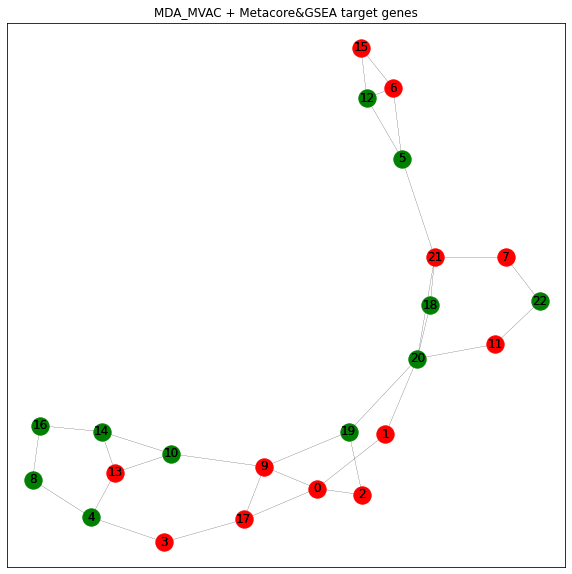

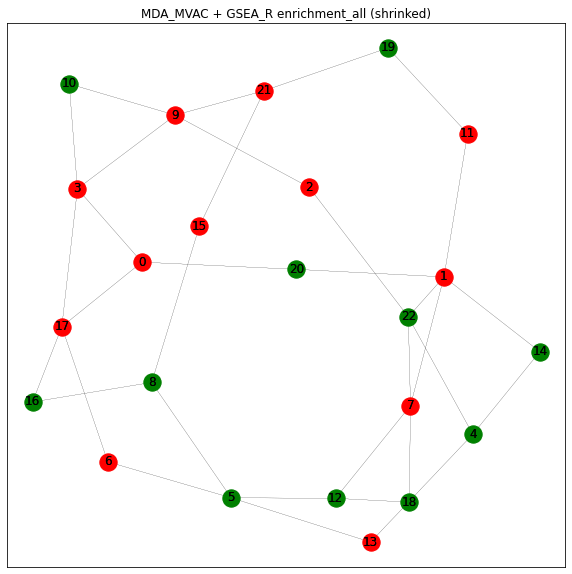

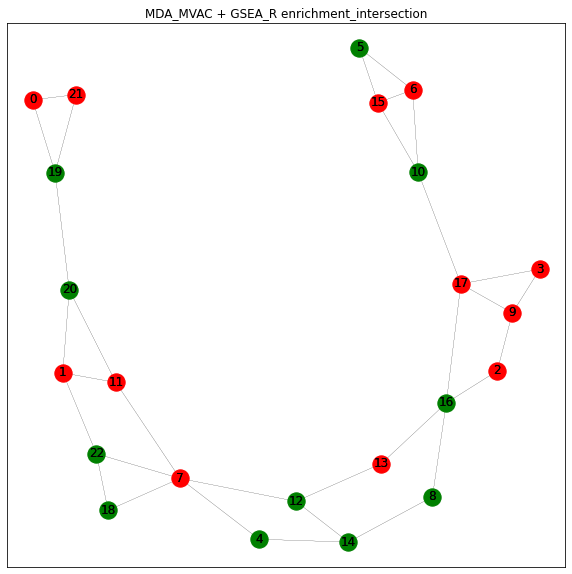

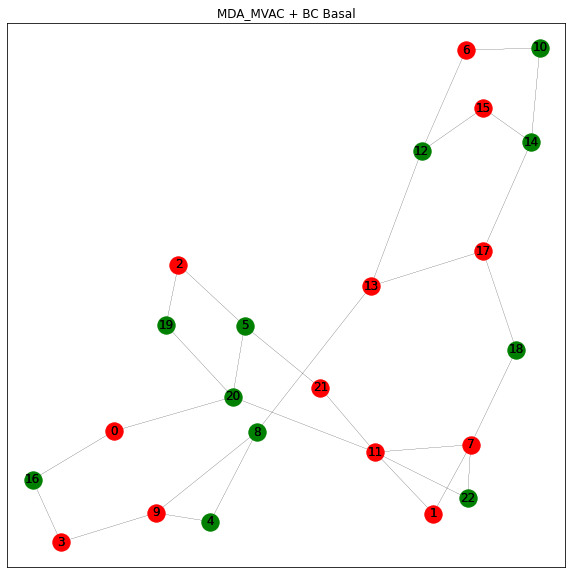

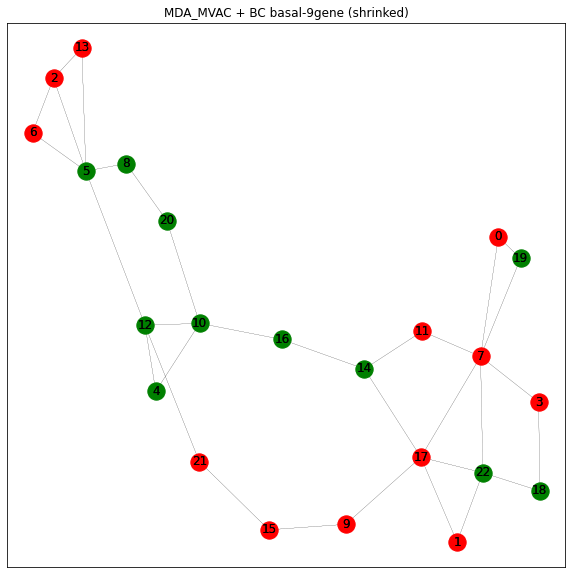

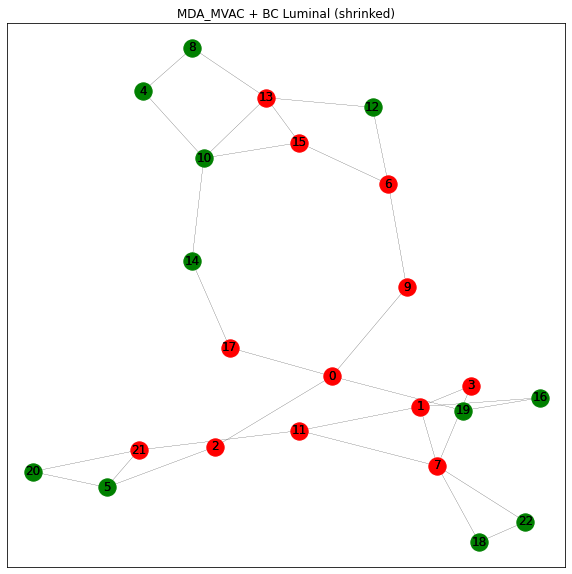

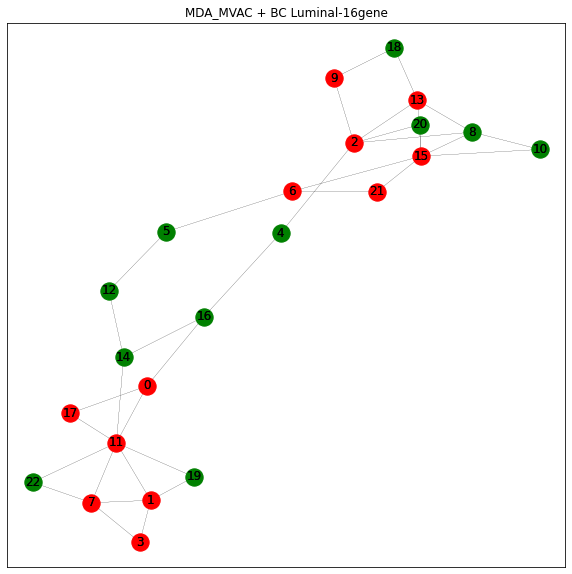

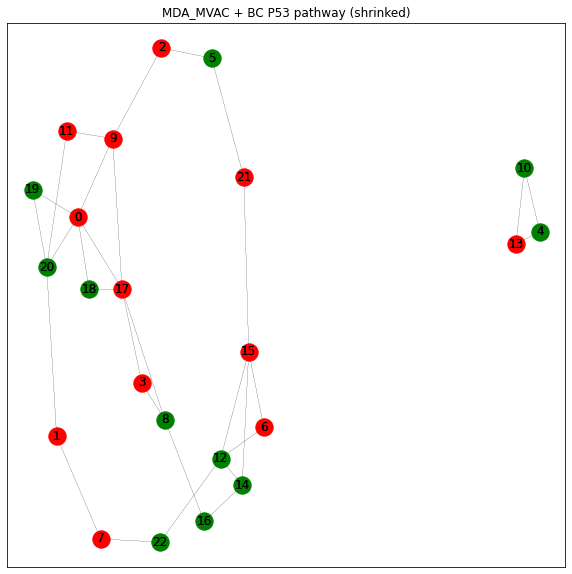

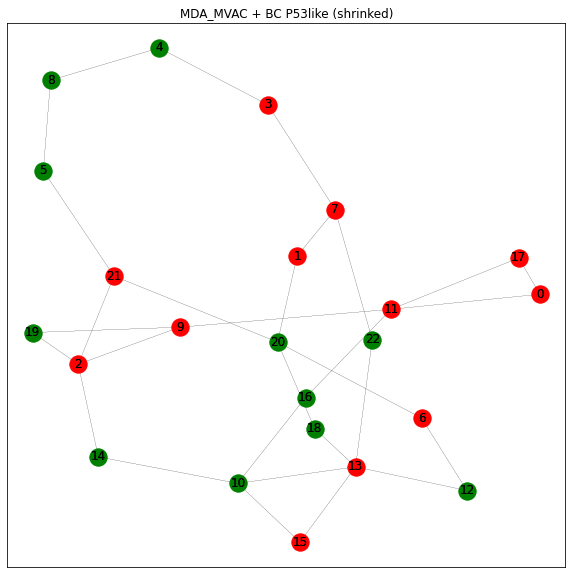

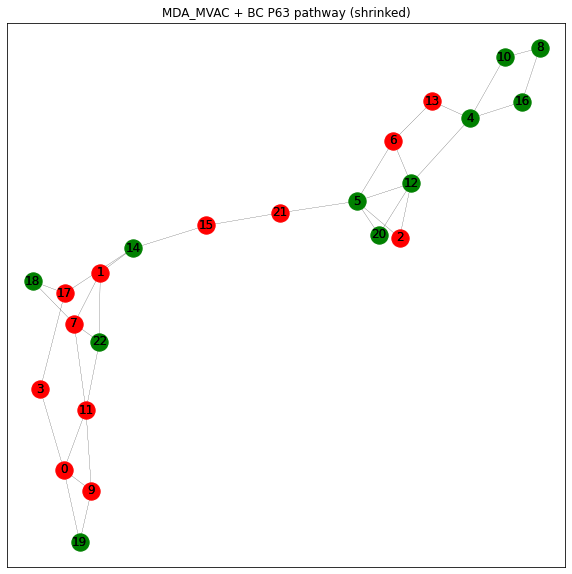

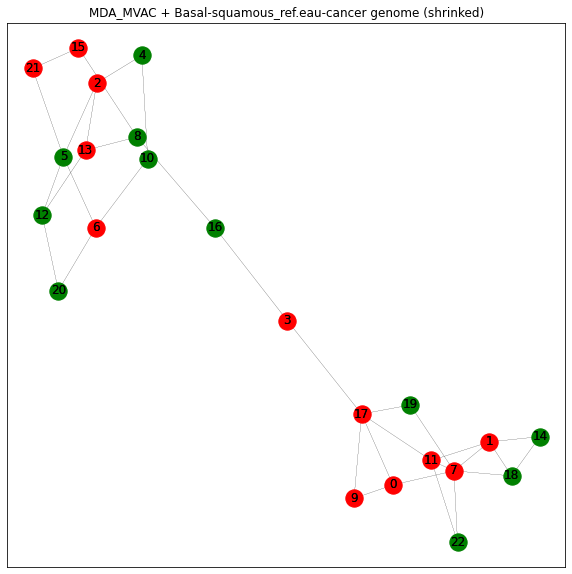

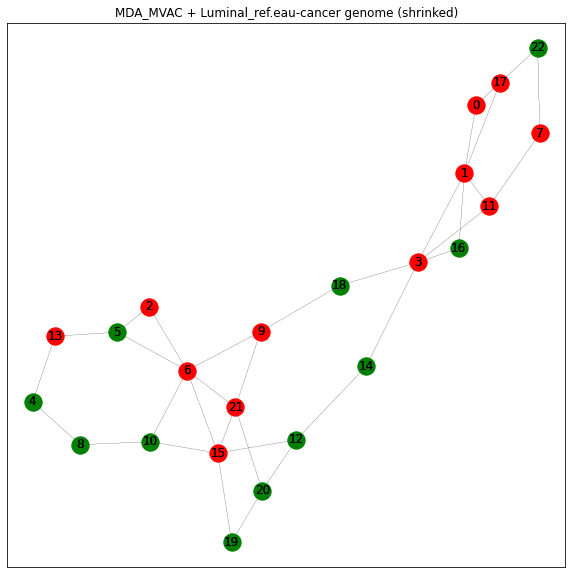

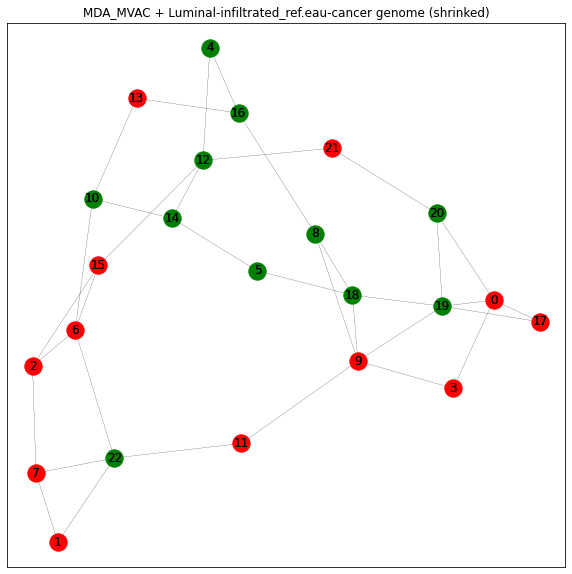

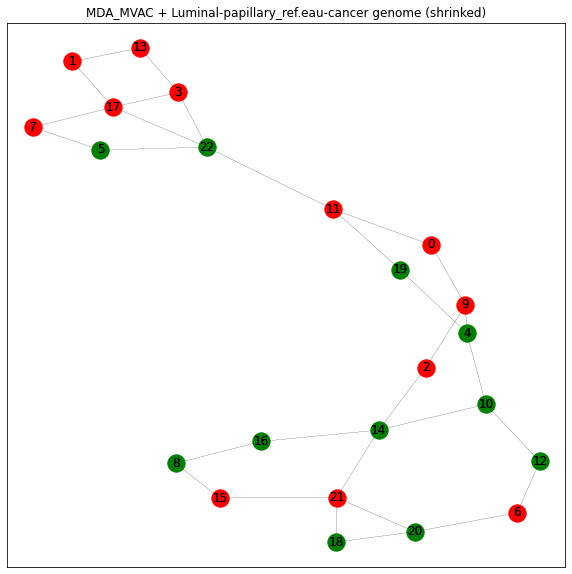

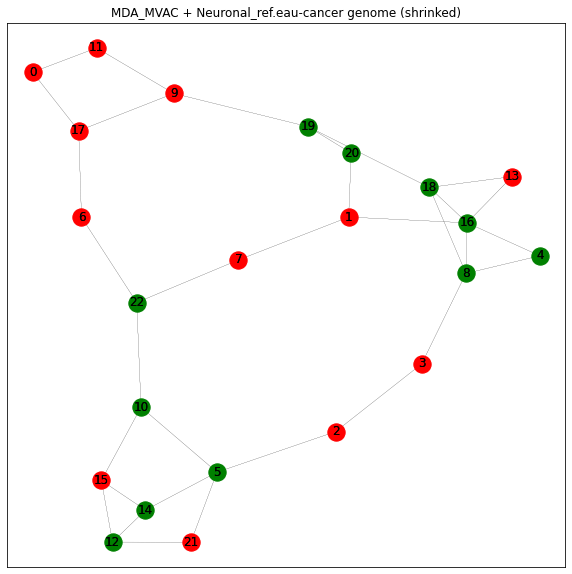

The best classifier is Luminal-papillary_ref.eau-cancer genome of 0.027462659652218054 and the mean silhouette score is 0.002161089999229313
CPU times: user 5.96 s, sys: 1.61 s, total: 7.56 s
Wall time: 5.76 s


In [37]:
%%time
mda_mvac_classifier = draw_data_network(Xy, selected_feature_dict, 'MDA_MVAC', 2)

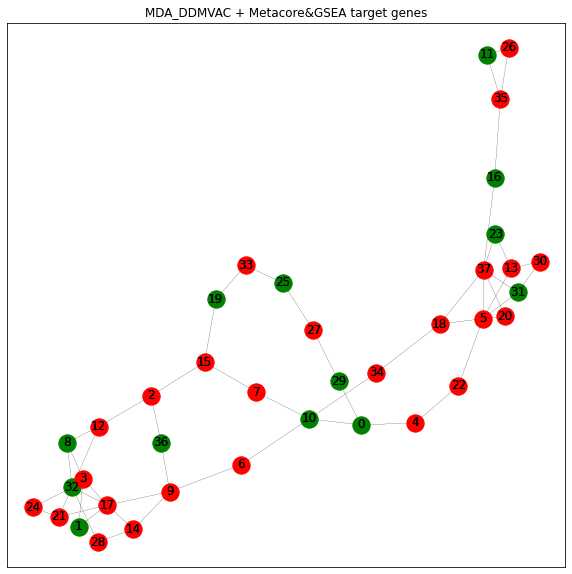

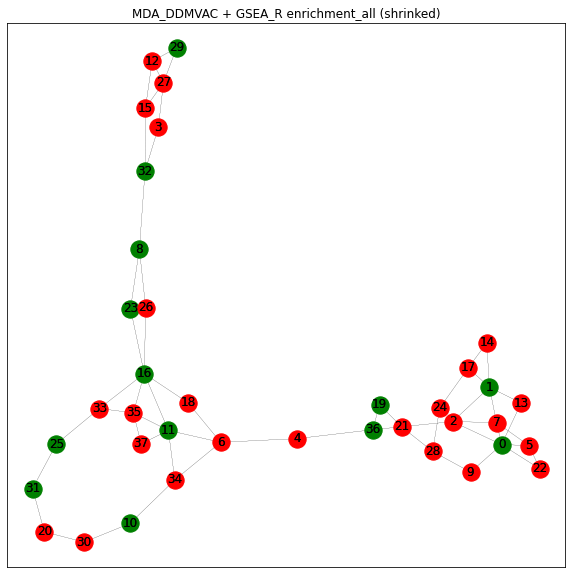

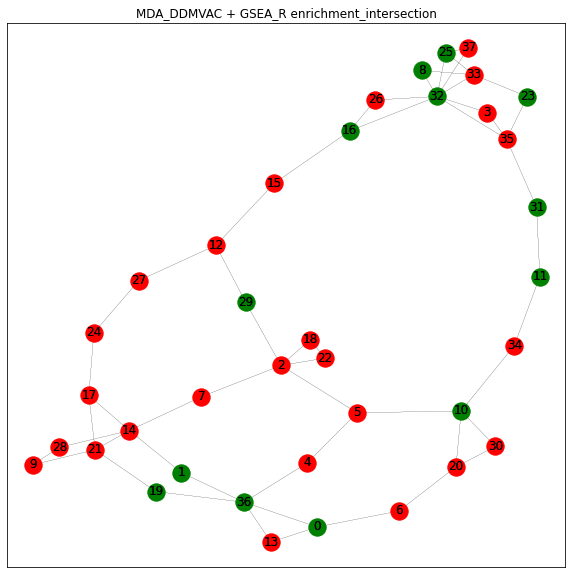

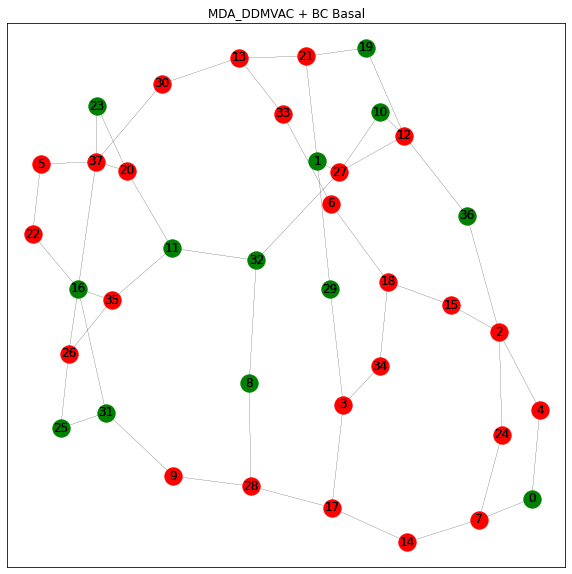

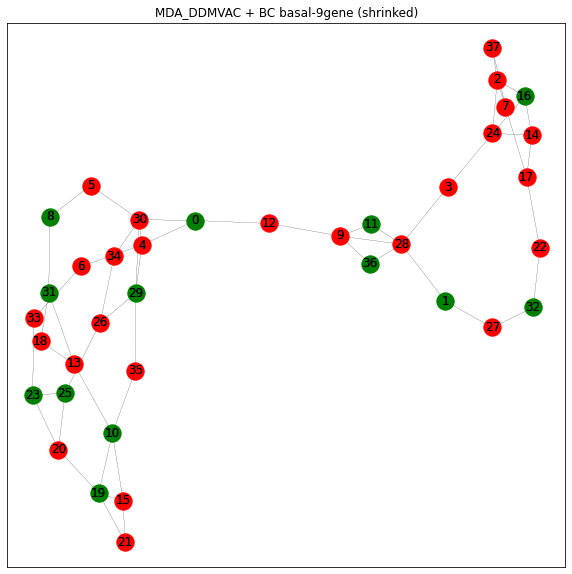

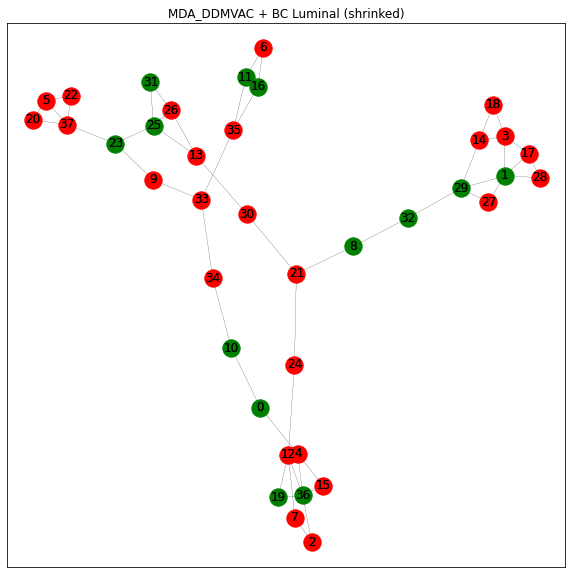

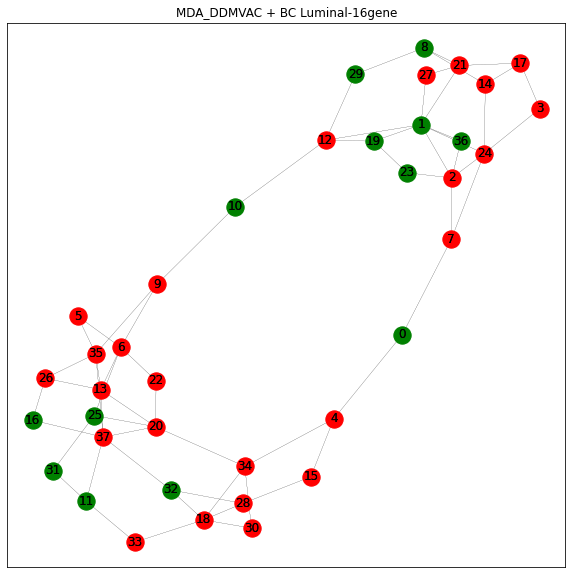

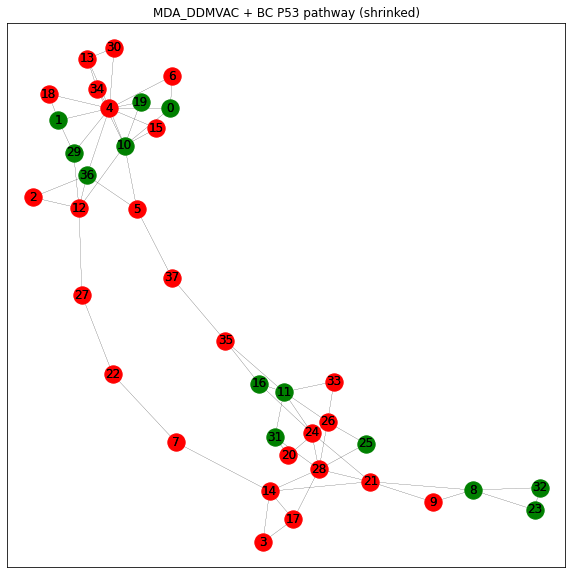

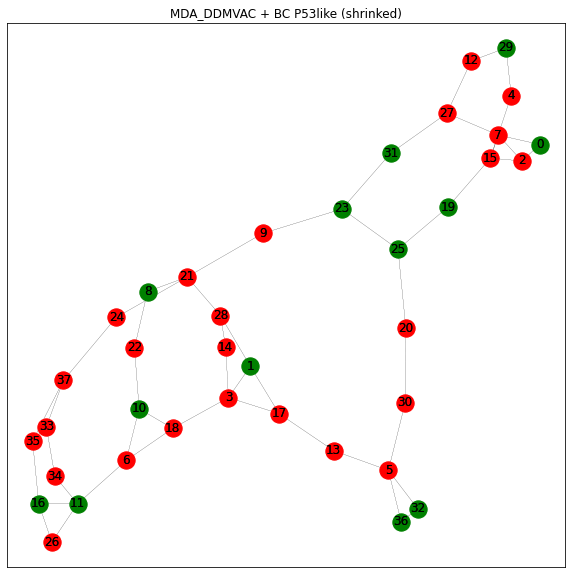

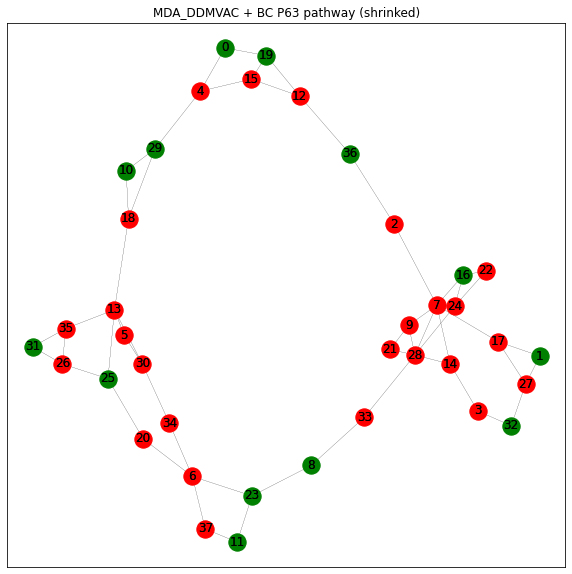

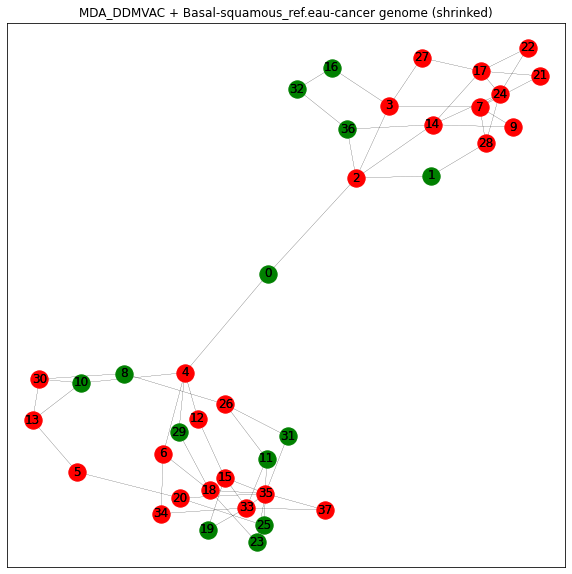

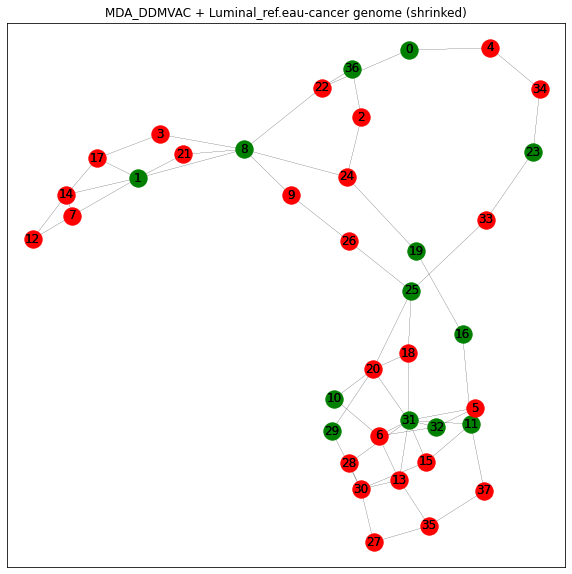

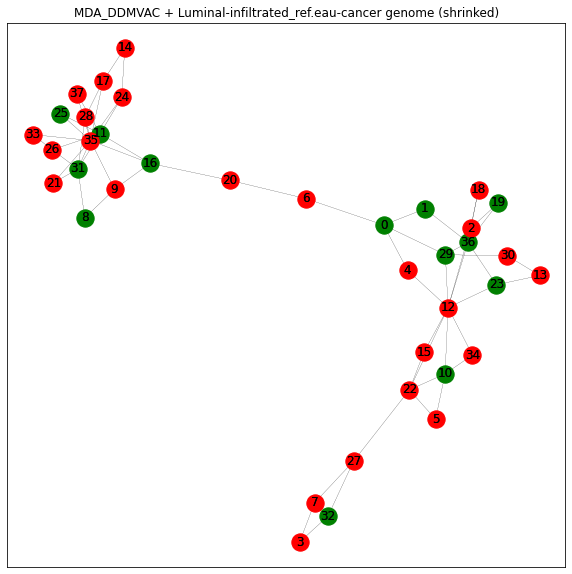

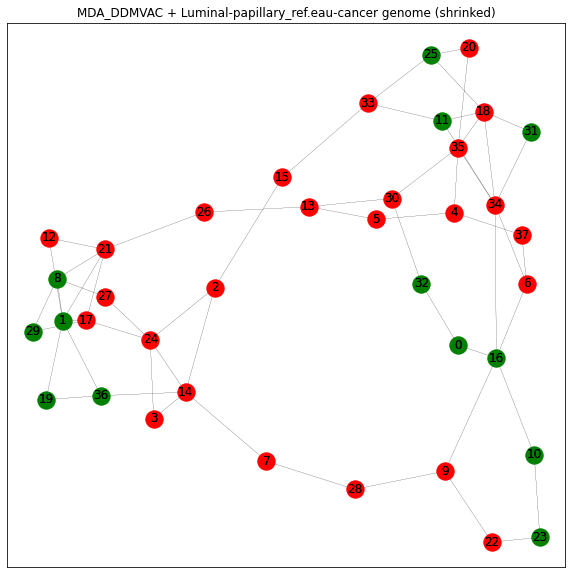

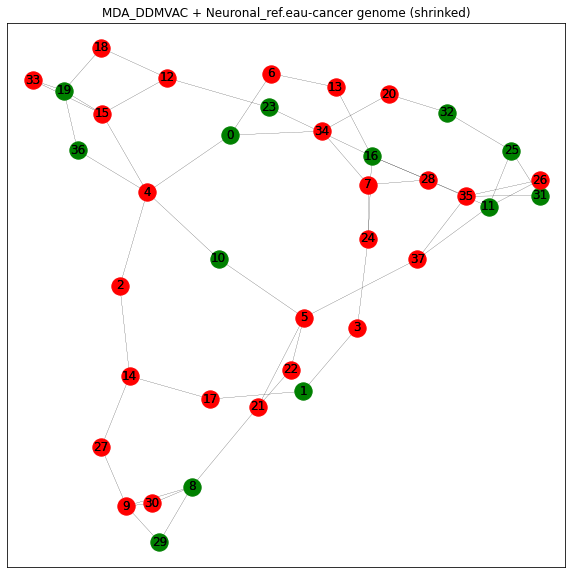

The best classifier is Luminal-infiltrated_ref.eau-cancer genome of 0.024054229650241003 and the mean silhouette score is 0.001961610415626409
CPU times: user 6.64 s, sys: 1.73 s, total: 8.37 s
Wall time: 6.4 s


In [38]:
%%time
mda_ddmvac_classifier = draw_data_network(Xy, selected_feature_dict, 'MDA_DDMVAC', 2)

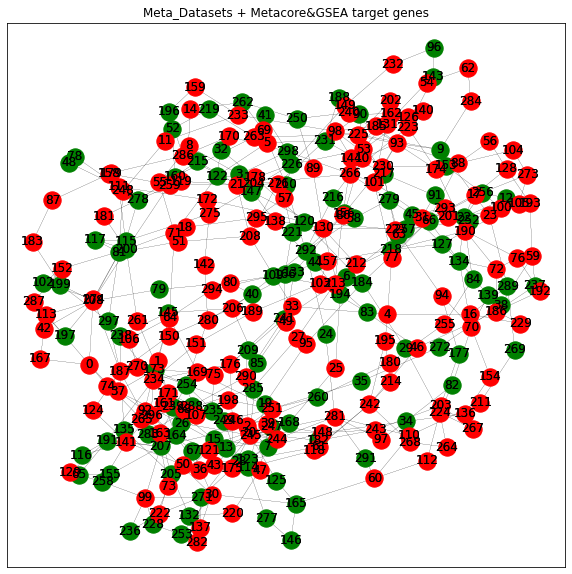

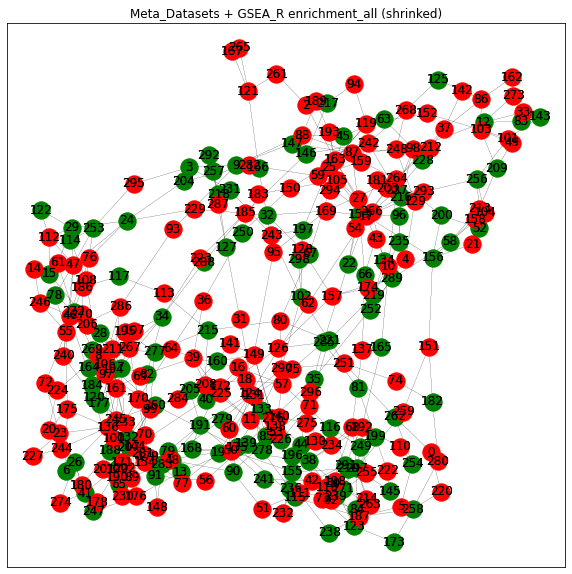

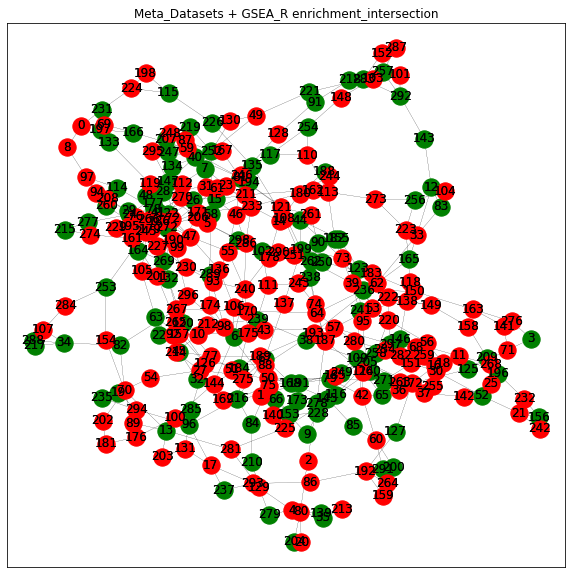

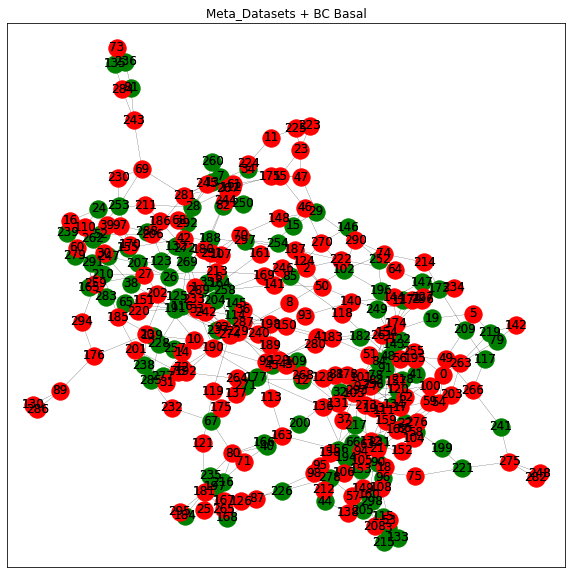

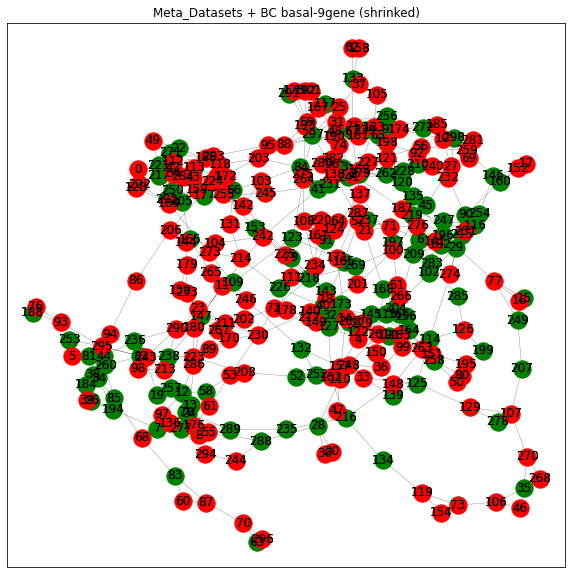

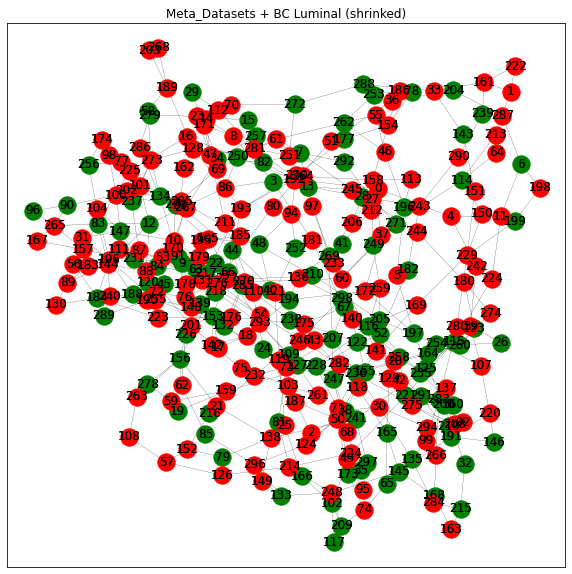

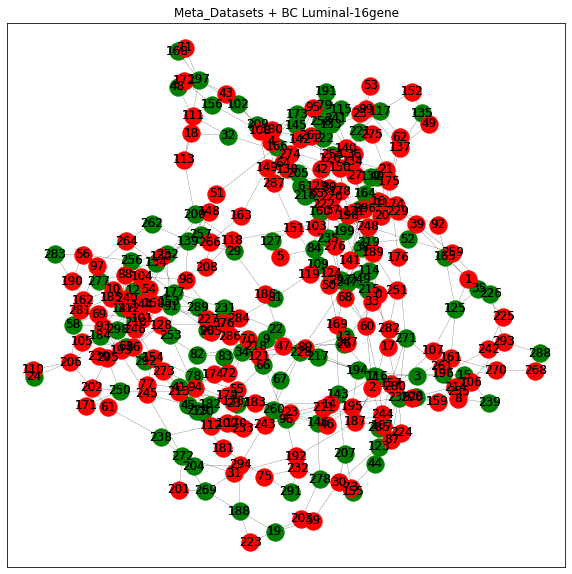

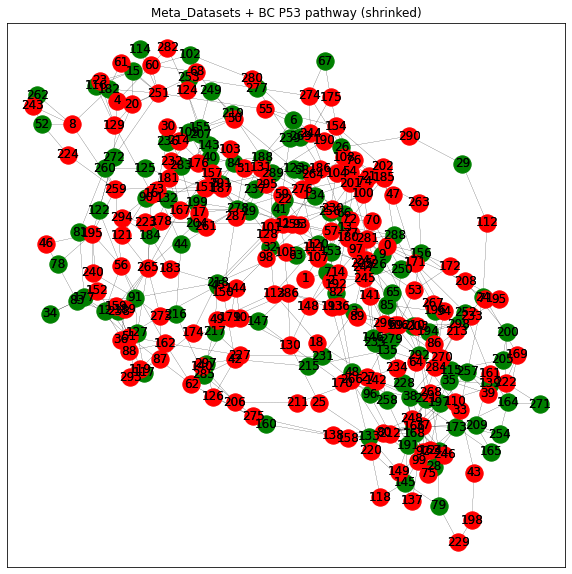

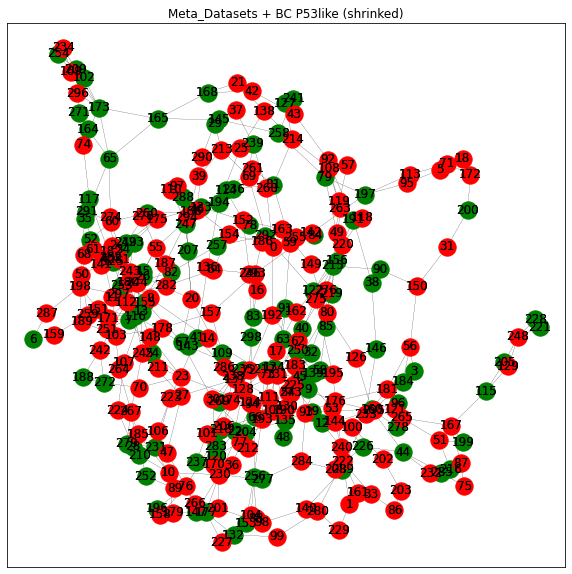

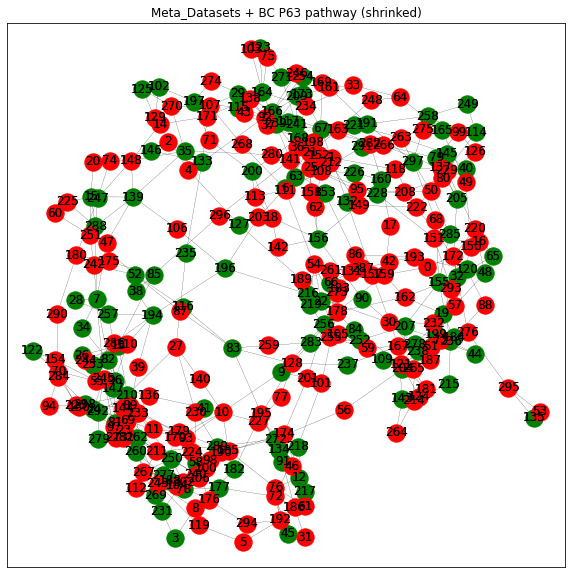

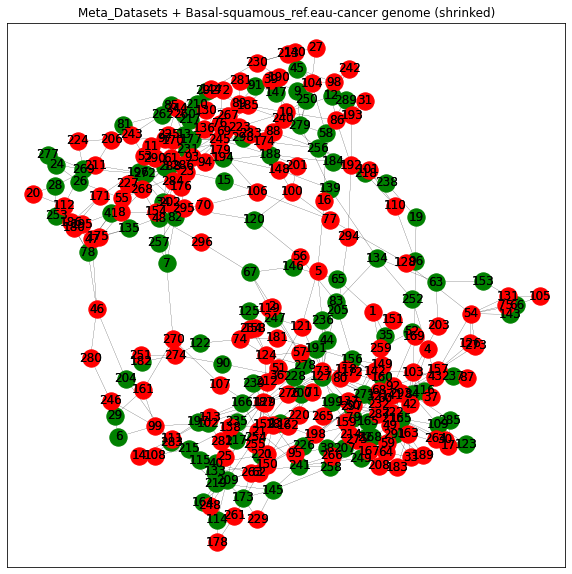

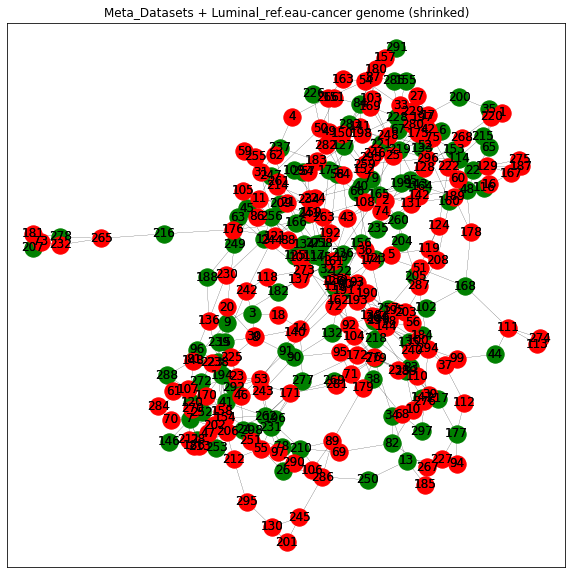

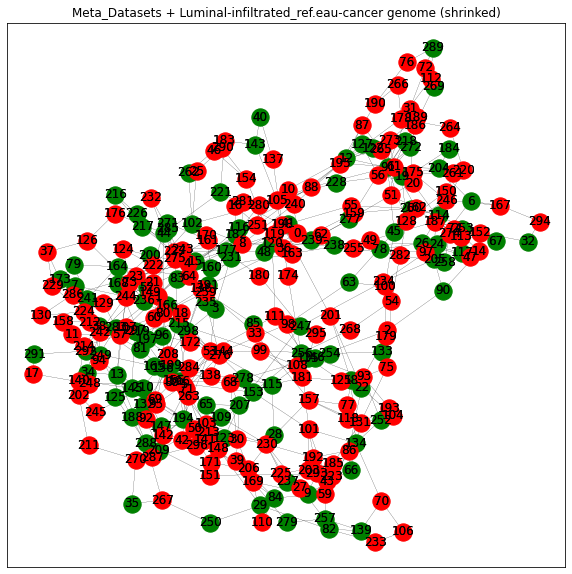

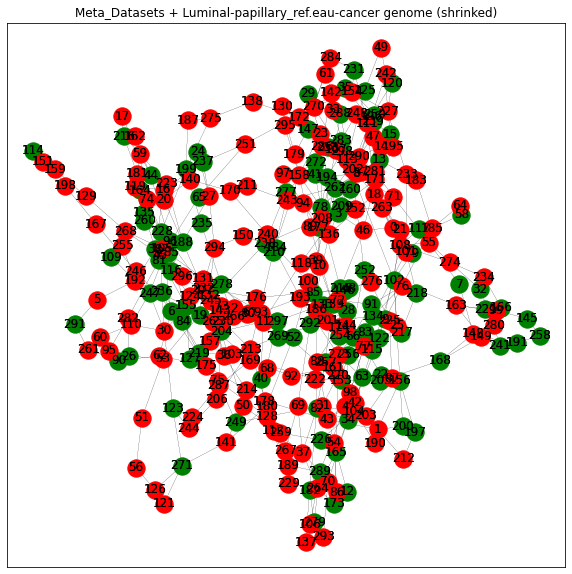

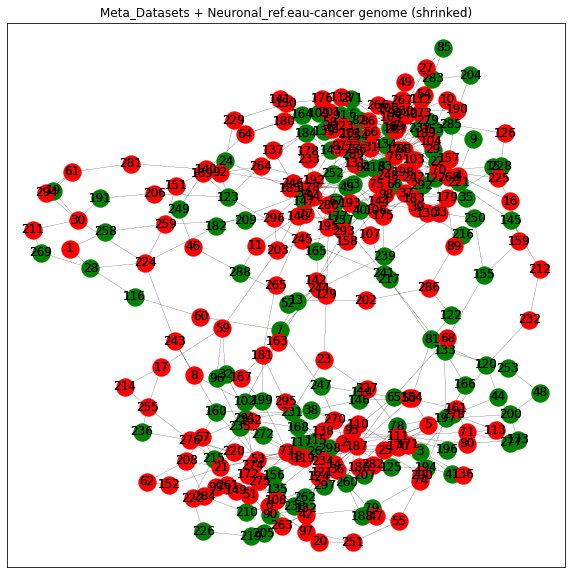

The best classifier is BC P53 pathway of 0.002920515049751448 and the mean silhouette score is 0.00020511061479458096
CPU times: user 29.7 s, sys: 4.8 s, total: 34.5 s
Wall time: 30.6 s


In [35]:
%%time
meta_datasets_classifier = draw_data_network(Xy, selected_feature_dict, 'Meta_Datasets', 2)

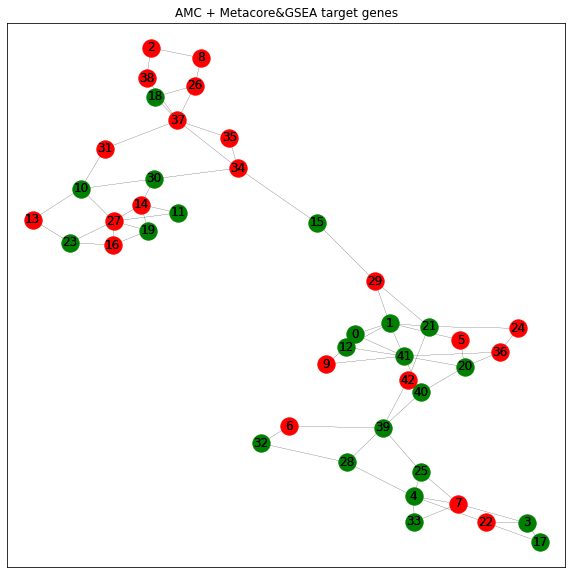

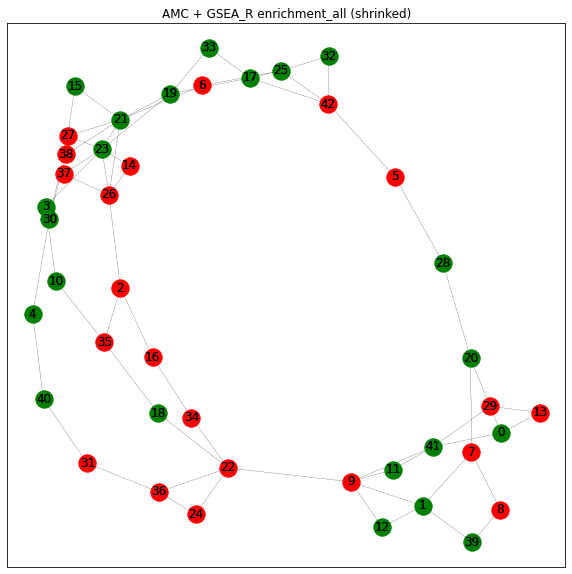

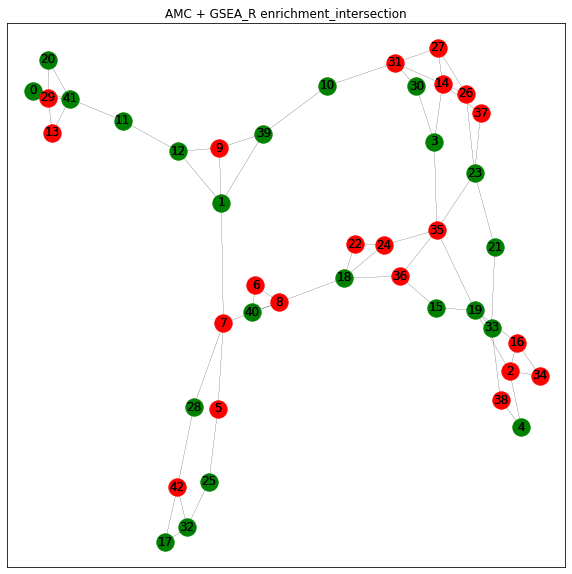

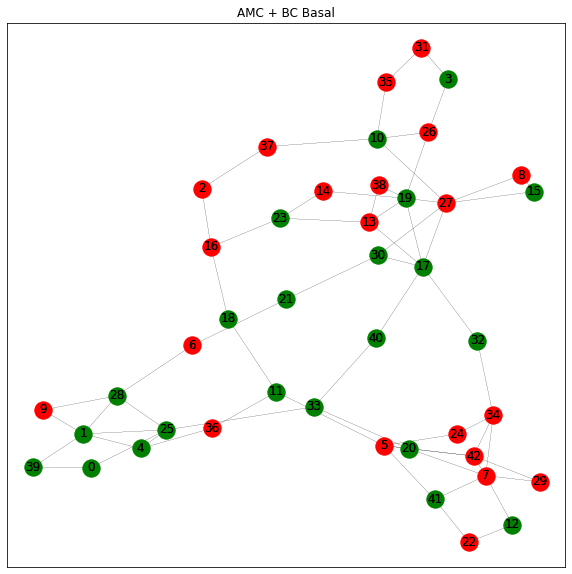

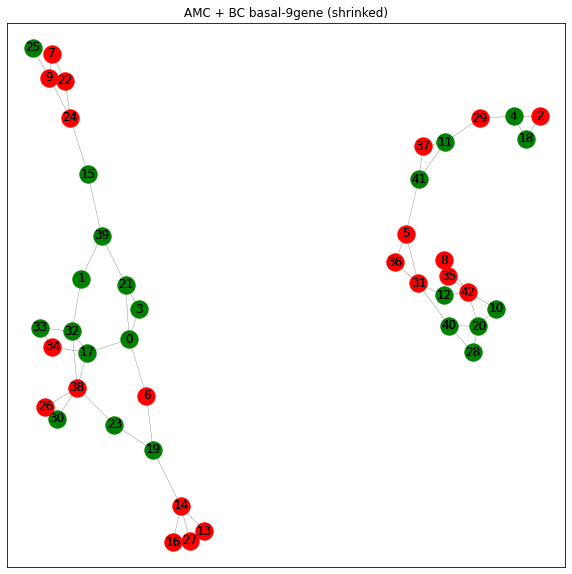

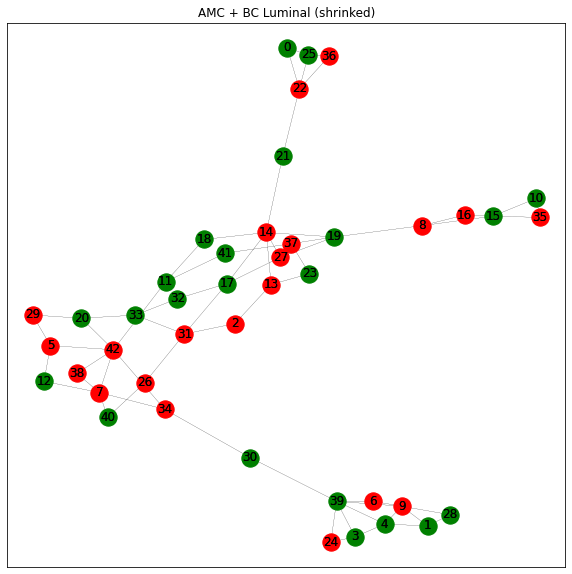

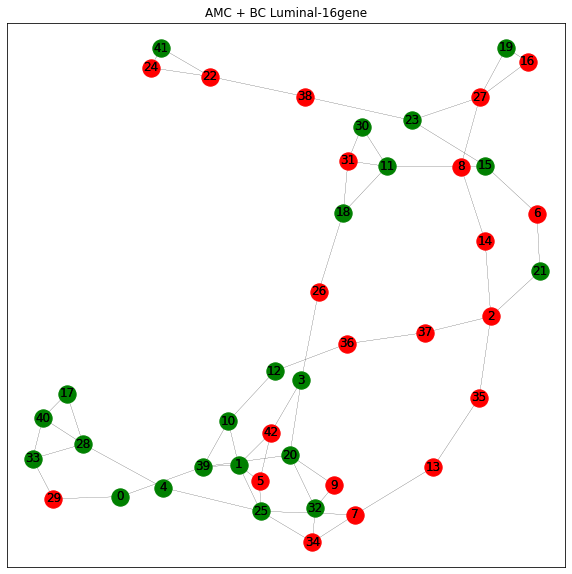

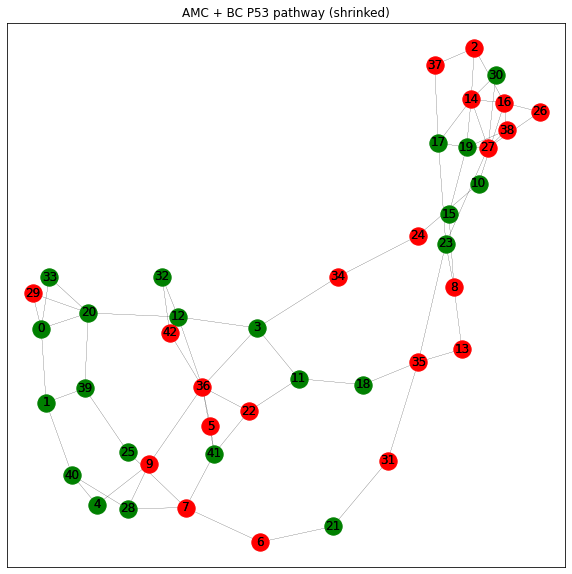

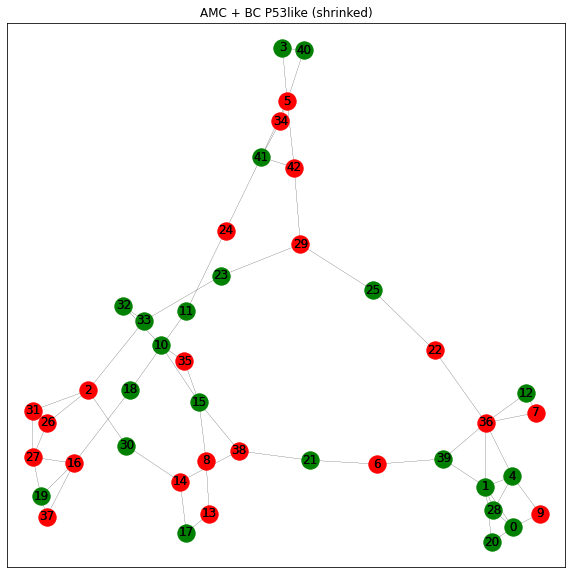

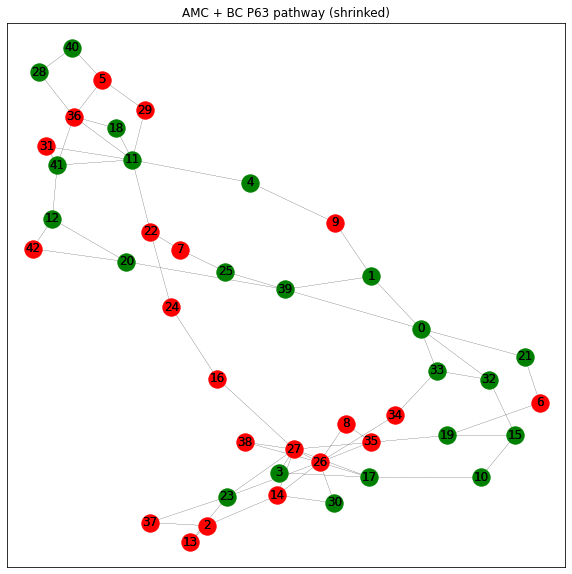

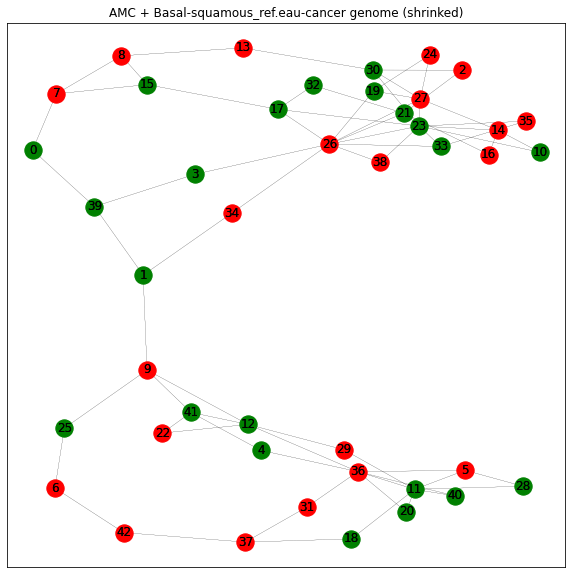

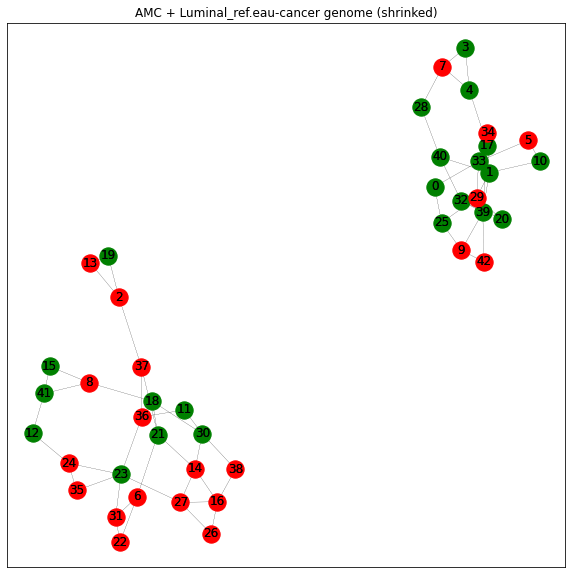

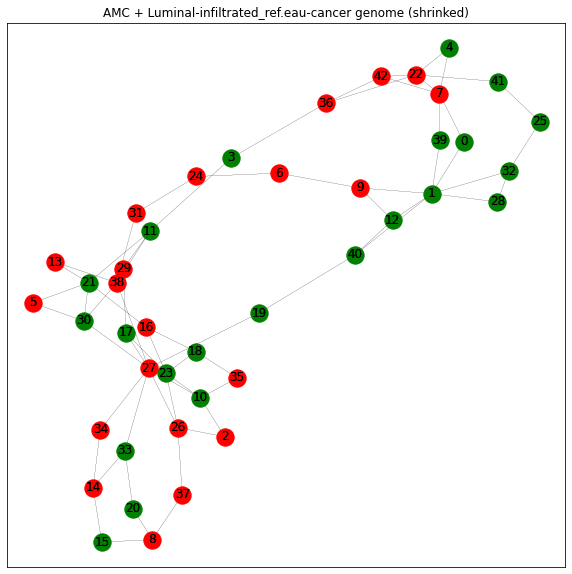

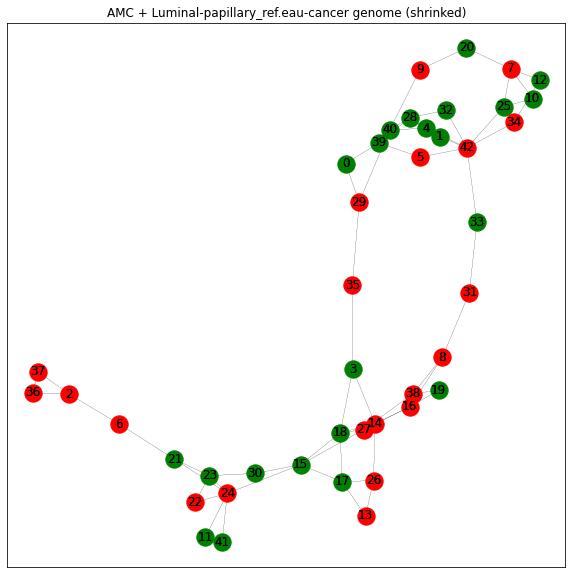

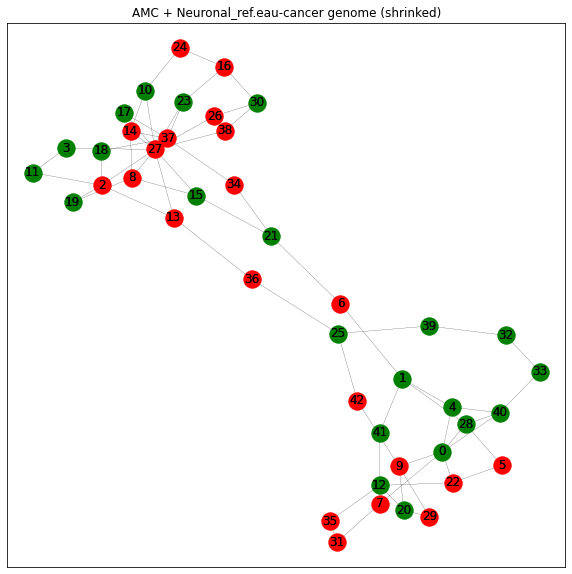

The best classifier is BC P63 pathway of 0.024107941411948604 and the mean silhouette score is 0.007442836040615625
CPU times: user 6.78 s, sys: 1.78 s, total: 8.56 s
Wall time: 6.58 s


In [36]:
%%time
amc_classifier = draw_data_network(Xy, selected_feature_dict, 'AMC', 2)

4. data-drien new classifier 도출

In [26]:
X = pd.concat([train_test_dict[best_scaler][0], train_test_dict[best_scaler][1]])
null_cnt = X.isnull().sum(0)
to_remove = []
for c in X.columns:
  if null_cnt[c] > 0:
    to_remove.append(c)
to_remove

['ASCL4',
 'C6orf118',
 'DGKK',
 'GNRHR',
 'GUCY1B2',
 'LIM2',
 'MYH2',
 'SERPINB12',
 'TCHHL1',
 'UGT2B28',
 'XAGE5',
 'ZNF233']

In [27]:
Xy = [X.drop(to_remove, 1), np.concatenate([train_y, test_y])]

In [28]:
%%time
opt_classifier = find_opt_classifier(list(Xy[0].columns), best_scaler, Xy, None, 10000, (0.0005, 0.003), 0.0001, 0.2)

{'auc': 0.9935279965361742, 'prauc': 0.9912896556951516, 'silhouette_score': 0.005431740933413341} 1.984817652231326
{'auc': 0.7886644051042415, 'prauc': 0.7399513188296325, 'silhouette_score': 0.01702079422769817} 1.528615723933874
{'auc': 0.7900058819684989, 'prauc': 0.72653431406656, 'silhouette_score': 0.015860954474179702} 1.5165401960350589
{'auc': 0.8190321710999281, 'prauc': 0.7654135031691456, 'silhouette_score': 0.01755010450805201} 1.5844456742690736
{'auc': 0.837024540879681, 'prauc': 0.792715102274812, 'silhouette_score': 0.014974374924518875} 1.629739643154493
{'auc': 0.8427197977256389, 'prauc': 0.796519263337565, 'silhouette_score': 0.015202053412824157} 1.6392390610632037
{'auc': 0.8425831236520489, 'prauc': 0.8016639415422738, 'silhouette_score': 0.014724680672635325} 1.6442470651943228
{'auc': 0.8576839340565976, 'prauc': 0.827634763753099, 'silhouette_score': 0.013735666100568901} 1.6853186978096966
{'auc': 0.861643479184367, 'prauc': 0.8310399198072573, 'silhouette

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



features: 16987 to 49
CPU times: user 6min 16s, sys: 6.03 s, total: 6min 22s
Wall time: 4min 25s


In [29]:
ut.save_data(opt_classifier, f'{home_path}new_classifier.pkl', 'pickle')
opt_classifier 

{'all_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=50,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'opt_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=50,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'performance':                           auc     prauc  silhouette_score
 power + all + train  1.000000  1.000000  0.000723        
 power + opt + train  0.823176  0.784575  0.008416        ,
 'selected_features': array(['PITPNA', 'EIF4EBP3', 'TRUB1', 'RGPD1', 'DPY19L3', 'ZNF75A',
        'EIF2B2', 'APOBEC3B',

In [30]:
len(opt_classifier['selected_features']), opt_classifier['selected_features']

(49, array(['PITPNA', 'EIF4EBP3', 'TRUB1', 'RGPD1', 'DPY19L3', 'ZNF75A',
        'EIF2B2', 'APOBEC3B', 'RAB8B', 'HOOK3', 'CABLES1', 'SLC6A3',
        'OR8J1', 'TSFM', 'ZBTB24', 'XYLT1', 'AP4M1', 'SNORA6', 'TCF7',
        'PTGIR', 'DOCK8', 'ZNF300', 'FAM149B1', 'CHID1', 'OR1F1',
        'C7orf55', 'PBLD', 'LMBR1L', 'XKR7', 'CLN8', 'POGK', 'CCDC54',
        'NFRKB', 'RNF126P1', 'GNG13', 'CD300E', 'KIR2DL4', 'TAS2R38',
        'UPK3A', 'AHCYL2', 'POPDC2', 'DNAJB2', 'SYT1', 'DAZL', 'AARS',
        'SCRT1', 'ASB7', 'HDAC6', 'MUC2'], dtype=object))

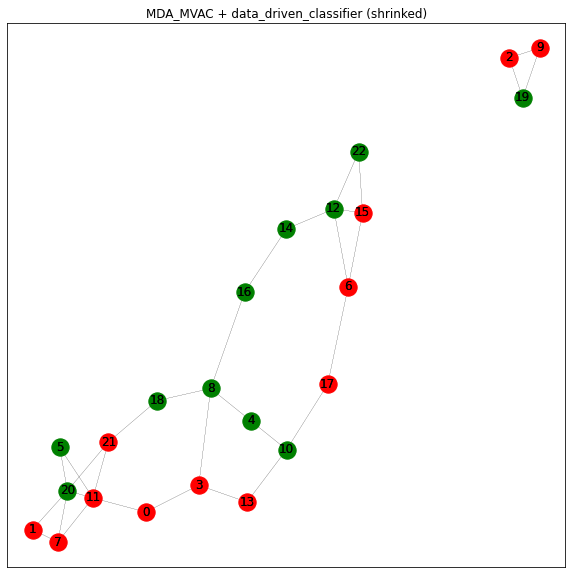

The best classifier is data_driven_classifier of 0.015638150531542067 and the mean silhouette score is 0.015638150531542067


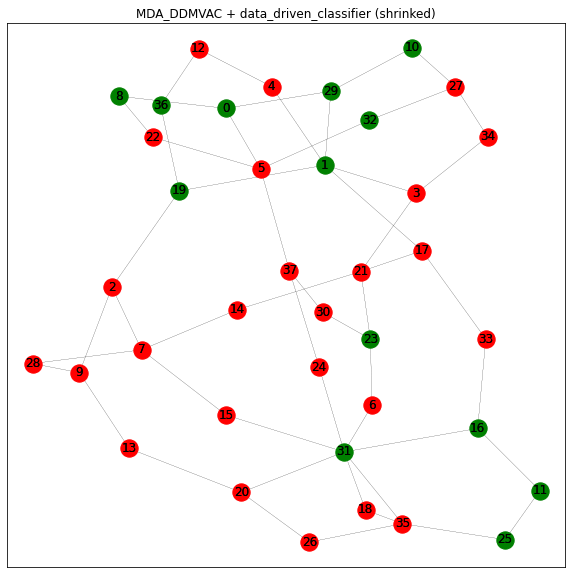

The best classifier is data_driven_classifier of 0.0068583931563639565 and the mean silhouette score is 0.0068583931563639565


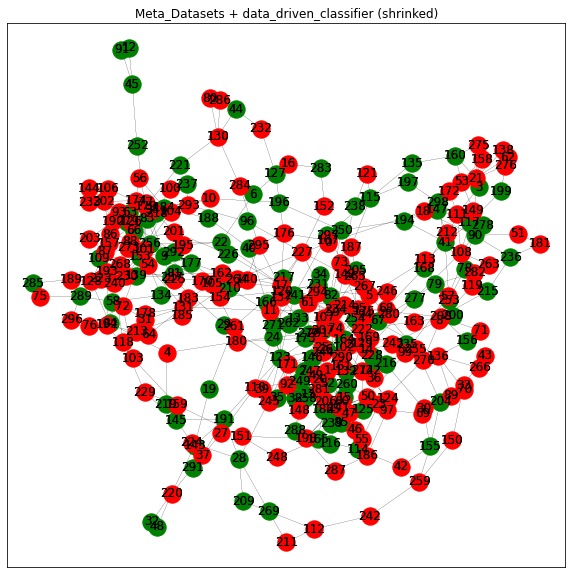

The best classifier is data_driven_classifier of 0.006780960192318152 and the mean silhouette score is 0.006780960192318152


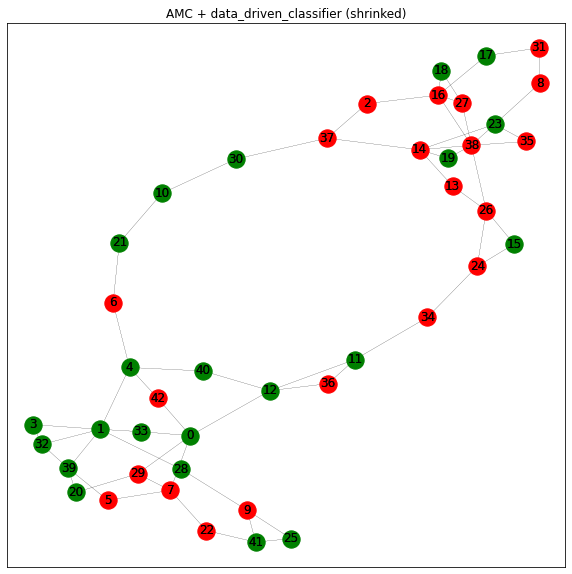

The best classifier is data_driven_classifier of 0.022766485406404174 and the mean silhouette score is 0.022766485406404174
CPU times: user 3.3 s, sys: 681 ms, total: 3.98 s
Wall time: 3.26 s


In [39]:
%%time
for dl in data_labels:
  draw_data_network(Xy, {'data_driven_classifier': (opt_classifier['selected_features'], True)}, dl, 2)